In [1]:
from fastai2.vision.all import *
from moving_mnist.models.tcn import *
from moving_mnist.models.conv_rnn import *
from moving_mnist.data import *

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print(torch.cuda.get_device_name())

Quadro RTX 8000


# Train TCN Example:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [3]:
Path.cwd()

Path('/home/tcapelle/SteadySun/moving_mnist')

In [4]:
DATA_PATH = Path.cwd()/'data'

In [5]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2], th=0.7)

In [6]:
train_tl = TfmdLists(range(7500), ImageTupleTransform(ds, cl_type=TensorMask))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds, cl_type=TensorMask))

In [7]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=64,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

In [8]:
loss_func = StackLoss(CrossEntropyLossFlat(axis=1))
metrics = [MultiImageDice(axis=1)]

Left: Input, Right: Target

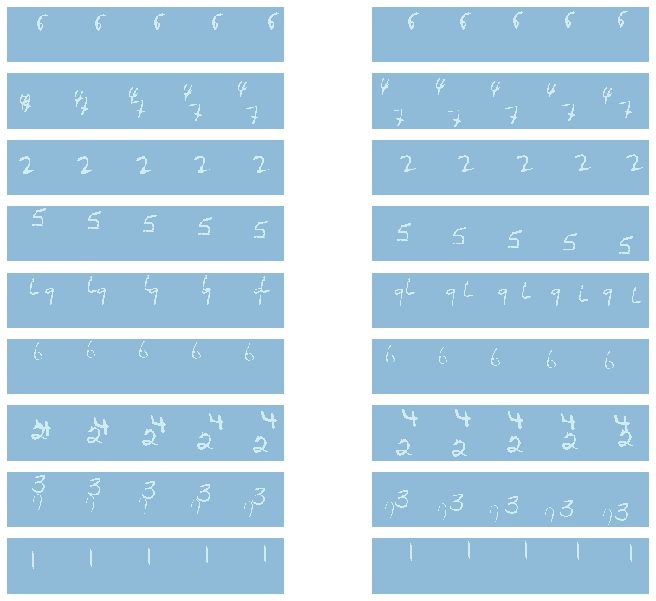

In [9]:
dls.show_batch()

## Baseline

`StackUnstack` takes cares of stacking the list of images into a fat tensor, and unstacking them at the end, we will need to modify our loss function to take a list of tensors as input and target.

In [10]:
stcn = SimpleTCN(n_out=2, dilation=1, debug=False)

In [11]:
stcn

SimpleTCN(
  (coord): TimeDistributed(CoordConv(
    (addcoords): AddCoords()
    (conv): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1))
  ))
  (conv0): TimeDistributed(ConvLayer(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  ))
  (tcn1): TemporalBlock3D(
    (conv1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 1, 1))
    (chomp1): Chomp(2)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 1, 1))
    (chomp2): Chomp(2)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (net): Sequential(
      (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 1, 1))
      (1): Chomp(2)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv3d(16, 16, kernel_size=(3, 3, 3), strid

In [12]:
model = StackUnstack(stcn, dim=2).cuda()

As the `ImageSeq` is a `tuple` of images, we will need to stack them to compute loss.

In [13]:
learn = Learner(dls, model, loss_func=loss_func, metrics=metrics, cbs=[]).to_fp16(clip=0.1)

I have a weird bug that if I use `nn.LeakyReLU` after doing `learn.lr_find()` the model does not train (the loss get stucked).

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.5248074531555176)

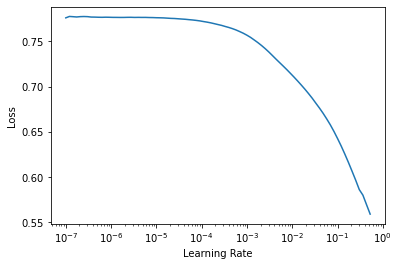

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(8, 1e-2)

epoch,train_loss,valid_loss,multi_image_dice,time
0,0.502142,0.436599,0.131961,00:19
1,0.293877,0.227868,0.148641,00:19
2,0.167234,0.159788,0.134421,00:19
3,0.129964,0.128349,0.189242,00:19
4,0.110220,0.120704,0.200348,00:19
5,0.101032,0.130252,0.149756,00:19
6,0.097736,0.122342,0.177605,00:19
7,0.095903,0.121473,0.184902,00:19


In [16]:
p,t = learn.get_preds(1)

As you can see, the results is a list of 5 tensors with 100 samples each.

In [17]:
len(p), p[0].shape

(5, torch.Size([100, 2, 64, 64]))

In [18]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

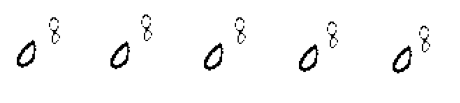

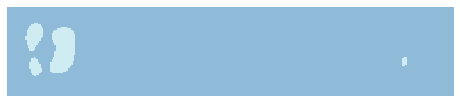

In [19]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k, True)